In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()
Base = automap_base()

In [6]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)
# reflect the tables

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)

In [11]:
inspector.get_table_names()

['measurement', 'station']

In [12]:
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
measure_df = pd.read_sql('select * from measurement;',conn)
measure_df.loc[measure_df['date']=='2016-08-23']

,id,station,date,prcp,tobs
2363,2364,USC00519397,2016-08-23,0.00,81.0
5090,5091,USC00513117,2016-08-23,0.15,76.0
7330,7331,USC00514830,2016-08-23,0.05,80.0
8824,8825,USC00517948,2016-08-23,NaN,80.0
11850,11851,USC00519523,2016-08-23,0.02,80.0
14607,14608,USC00519281,2016-08-23,1.79,77.0
19201,19202,USC00516128,2016-08-23,0.70,74.0


In [15]:
station_df = pd.read_sql('select * from station;',conn)
station_df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


# Exploratory Climate Analysis

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#data = pd.read_sql("SELECT * FROM Measurement WHERE date > '2017-01-01' AND date < '2018-01-01'", conn)
#data = pd.read_sql("SELECT * FROM Measurement ORDER BY Id DESC;", conn)
#dates = pd.read_sql("SELECT date, prcp FROM Measurement WHERE date >= '2016-08-23' AND date <= '2017-08-23'", conn)
#dates.head()
last_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_day[0])
first_day = dt.date(2017,8,23)-dt.timedelta(days=365)
print(first_day)
# Perform a query to retrieve the data and precipitation scores


2017-08-23
2016-08-23


In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_date = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date>=first_day).\
order_by(Measurement.date).all()
prcp_date_df = pd.DataFrame(prcp_date, columns=['Date', 'Precipitaion'])
# Sort the dataframe by date
prcp_date_df = prcp_date_df.sort_values('Date')
prcp_date_df.set_index(['Date'], inplace=True)
prcp_date_df.head()

,Precipitaion
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


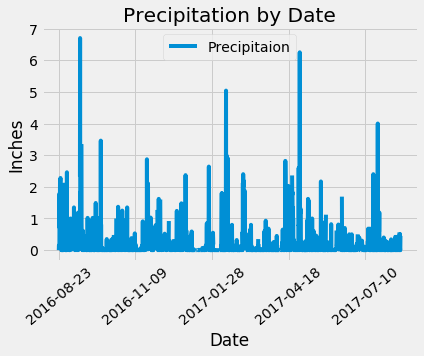

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_date_df.plot(rot=40)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title ('Precipitation by Date')
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_date_df.describe()

,Precipitaion
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.id)).first()[0]
print(f'There are {station_count} stations.')

There are 9 stations.


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f'Stations {station_activity} is most active.')
station_activity

Stations [('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)] is most active.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
tob_measure_ls = session.query(func.max(Measurement.tobs),func.min(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.date>='2016-08-23').\
filter(Measurement.station =='USC00519281').all()[0]
tob_measure_ls
print(f'The max temp recorded is {tob_measure_ls[0]} the min temp recorded is {tob_measure_ls[1]} the average temp recorded is {round(tob_measure_ls[2],2)}.')

The max temp recorded is 83.0 the min temp recorded is 59.0 the average temp recorded is 73.11.


In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_query_ls = session.query(Measurement.tobs).\
filter(Measurement.date>='2016-08-23').\
filter(Measurement.station == 'USC00519281').\
order_by(Measurement.tobs).all()
tobs_df = pd.DataFrame(tobs_query_ls)
tobs_df.head()

,tobs
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


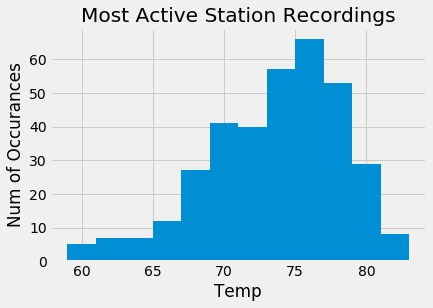

In [29]:
tobs_df.hist(bins=12)
plt.xlabel('Temp')
plt.ylabel('Num of Occurances')
plt.title('Most Active Station Recordings')
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
